In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import time
from keras_tuner import HyperModel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish_D1_I7000_F9000/TPath_500_finish_data_D1.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,500,7000,9000,669.05
1,0.0000,-0.00199,500,7000,9000,675.83
2,0.0000,-0.00198,500,7000,9000,682.81
3,0.0000,-0.00197,500,7000,9000,689.82
4,0.0000,-0.00196,500,7000,9000,696.80
...,...,...,...,...,...,...
100646,0.0025,0.00196,500,7000,9000,578.47
100647,0.0025,0.00197,500,7000,9000,576.89
100648,0.0025,0.00198,500,7000,9000,575.32
100649,0.0025,0.00199,500,7000,9000,573.76


In [4]:
df = data.drop(data.columns[2:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Temperatur
0,0.0000,-0.00200,669.05
1,0.0000,-0.00199,675.83
2,0.0000,-0.00198,682.81
3,0.0000,-0.00197,689.82
4,0.0000,-0.00196,696.80
...,...,...,...
100646,0.0025,0.00196,578.47
100647,0.0025,0.00197,576.89
100648,0.0025,0.00198,575.32
100649,0.0025,0.00199,573.76


In [5]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen

print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Temperatur
83145       0.00207      -0.00062      1282.2
66701       0.00166      -0.00065      1347.6
91325       0.00227       0.00098      1094.6
46593       0.00116      -0.00123      1175.7
49518       0.00123      -0.00005      1459.2
...             ...           ...         ...
6265        0.00015       0.00050      1439.1
54886       0.00136       0.00150       876.7
76820       0.00191       0.00029      1335.8
860         0.00002      -0.00142      1071.2
15795       0.00039      -0.00044      1488.1

[100651 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00207,-0.00062,1282.2
1,0.00166,-0.00065,1347.6
2,0.00227,0.00098,1094.6
3,0.00116,-0.00123,1175.7
4,0.00123,-0.00005,1459.2
...,...,...,...
100646,0.00015,0.00050,1439.1
100647,0.00136,0.00150,876.7
100648,0.00191,0.00029,1335.8
100649,0.00002,-0.00142,1071.2


In [6]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [7]:
X.describe()

,X-Koordinate,Y-Koordinate
count,100651.000000,1.006510e+05
mean,0.001250,1.103042e-20
std,0.000725,1.157589e-03
min,0.000000,-2.000000e-03
25%,0.000620,-1.000000e-03
50%,0.001250,4.529900e-18
75%,0.001880,1.000000e-03
max,0.002500,2.000000e-03


In [8]:
y.describe()


count    100651.000000
mean       1144.030064
std         264.135723
min         572.200000
25%         937.330000
50%        1201.100000
75%        1368.700000
max        1520.000000
Name: Temperatur, dtype: float64

In [9]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [10]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [11]:
X_train_scaled

array([[0.416 , 0.5725],
       [0.812 , 0.7325],
       [0.628 , 0.5075],
       ...,
       [0.604 , 0.3875],
       [0.748 , 0.65  ],
       [0.028 , 0.6225]])

In [23]:
start_time = time.time()
# Netzwerkarchitektur
model = Sequential([
    # Eingabeschicht
    Dense(224, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    #Dropout(0.01),
    # Versteckte Schicht
    Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    Dense(96, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    #Dropout(0.01),
    # Ausgabeschicht für Regression (1 Einheit ohne Aktivierungsfunktion)
    Dense(224, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    Dense(352, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='min', restore_best_weights=True)#, min_delta = 0.00005)

# Trainingsparameter
batch_size = 200
epochs = 200

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose = 1)

end_time = time.time()

# Berechne die Dauer
duration = end_time - start_time

print(f"Die Ausführungszeit betrug {duration} Sekunden.")

Epoch 1/200
323/323 [==============================] - 2s 3ms/step - loss: 0.1719 - mae: 0.0765 - val_loss: 0.1117 - val_mae: 0.0109
Epoch 2/200
323/323 [==============================] - 1s 3ms/step - loss: 0.1030 - mae: 0.0131 - val_loss: 0.0951 - val_mae: 0.0107
Epoch 3/200
323/323 [==============================] - 1s 3ms/step - loss: 0.0892 - mae: 0.0130 - val_loss: 0.0833 - val_mae: 0.0114
Epoch 4/200
323/323 [==============================] - 1s 3ms/step - loss: 0.0784 - mae: 0.0087 - val_loss: 0.0736 - val_mae: 0.0054
Epoch 5/200
323/323 [==============================] - 1s 3ms/step - loss: 0.0696 - mae: 0.0092 - val_loss: 0.0655 - val_mae: 0.0045
Epoch 6/200
323/323 [==============================] - 1s 3ms/step - loss: 0.0620 - mae: 0.0081 - val_loss: 0.0588 - val_mae: 0.0141
Epoch 7/200
323/323 [==============================] - 1s 3ms/step - loss: 0.0554 - mae: 0.0084 - val_loss: 0.0528 - val_mae: 0.0187
Epoch 8/200
323/323 [==============================] - 1s 3ms/step - 

In [24]:
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[1000]} Actual: {original_actual_values[1000]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")
    
    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]
    
    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)
    
    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")


 Bsp. Predicted: [1191.9076] Actual: [1195.9] 
Durchschnittliche Abweichung (MAE): [3.07670403]


In [26]:
df_result = pd.DataFrame({'Echt': [val[0] for val in list1], 'Vorhergesagt': [val[0] for val in list2]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]

df_result['Differenz'] = df_result['Echt'] - df_result['Vorhergesagt']
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] > 5).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)
 
sorted_df

Anzahl der Werte die kleiner sind: 1327


,Echt,Vorhergesagt,X-Koordinate,Y-Koordinate,Differenz
4472,559.645264,589.58,0.580,1.0000,-29.934736
17844,560.029968,589.93,0.568,1.0000,-29.900032
14372,561.057007,590.84,0.536,1.0000,-29.782993
16327,559.405151,589.10,0.596,1.0000,-29.694849
7952,561.570374,591.26,0.520,1.0000,-29.689626
...,...,...,...,...,...
14839,627.143005,599.38,0.956,0.9725,27.763005
15061,615.466980,587.18,0.956,0.9775,28.286980
11939,615.796448,586.88,0.964,0.9775,28.916448
13809,622.623901,593.15,0.988,0.9750,29.473901


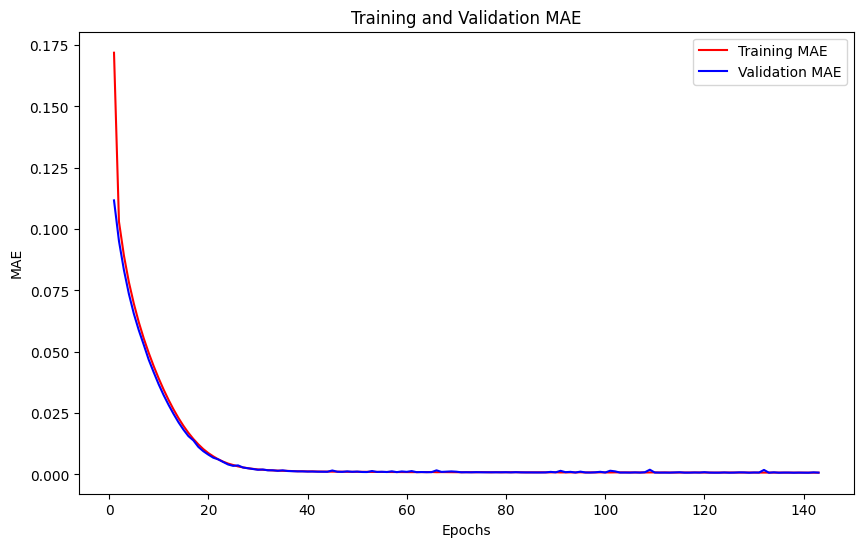

In [37]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)
# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


# GridSearch
Grid Search bietet die Vorteile der anpassbaren Rechenzeit sowie die Möglichkeit des EInsatzes von Verteilungen. So können theoretisch Hyperparamterkonfuigurationen gefunden wende, welche durch GridSearch nicht auffindbar wären. ZUdem ist das Ziel der Hyperparamteroptimierung eine Einstellung zu finden, welche auf Trainings und Testset gut angepasst ist. Die EInstellung muss nicht die bestmöglichste Einstellung sein, sondern eine Einstellung die das gewähltre Problem gut wiederspiegelt. 
Bayesian Optimierung

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV

def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(224, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization))),
    model.add(Dropout(dropout_rate)),
    model.add(Dense(32, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization))),
    model.add(Dropout(dropout_rate)),
    model.add(Dense(96, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization))),
    model.add(Dropout(dropout_rate)),
    model.add(Dense(224, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization))),
    model.add(Dropout(dropout_rate)),
    model.add(Dense(128, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization))),
    model.add(Dropout(dropout_rate)),
    model.add(Dense(352, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization))),
    model.add(Dropout(dropout_rate)),
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

# Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
model = KerasRegressor(model=build_model, verbose=2, epochs=30, dropout_rate = 'dropout_rate', learning_rate = 'learning_rate', regularization = 'regularization')

# Anpassung der Parameter im param_grid
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'regularization': [0.001, 0.0001],
    'dropout_rate': [0.0, 0.2],
    
}

fit_params = {
    'batch_size': [50, 100, 200, 500],
    'epochs': 30
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
grid_result = grid_search.fit(X_train_scaled, y_train_scaled, **fit_params)
# Beste Parameter und Score ausgeben
print("Beste Parameter:", grid_search.best_params_)
print("Beste Genauigkeit:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


ValueError: 
All the 36 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\erikm\Desktop\Diplomarbeit Erik Marr\Projekt X\venv\Lib\site-packages\keras\src\engine\data_adapter.py", line 275, in __init__
    self._size = int(math.ceil(num_samples / batch_size))
                               ~~~~~~~~~~~~^~~~~~~~~~~~
TypeError: unsupported operand type(s) for /: 'int' and 'list'


In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

# Funktion, um das Keras-Modell zu erstellen
def create_model(learning_rate=0.001,  regularization_rate=0.0001):
    model = Sequential([
        Dense(64, input_shape=(2,), activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='MSE', metrics=['MAE'])
    return model

# Wrapper um das Modell für Grid Search
model = KerasClassifier(build_fn=create_model, verbose=0, lr=None, optimizer=None)

# Definiere den Parameterraum für die Grid Search
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    #'dropout_rate': [0.0, 0.2, 0.5],
    'regularization_rate': [0.01, 0.001, 0.0001]
}

# Erstelle und führe die Grid Search aus
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_scaled, y_train_scaled)

# Ergebnisse
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score']:
    print("%f (%f) with: %r" % (mean_score, scores, params))


ValueError: Invalid parameter learning_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(learning_rate=0.001)`
Check the list of available parameters with `estimator.get_params().keys()`

In [37]:
class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Dense(
            units=hp.Int('units_input', min_value=16, max_value=124, step=16),
            activation='relu',
            input_shape=self.input_shape,
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(0.0001)
        ))
        model.add(Dense(
            units=hp.Int('units_hidden1', min_value=16, max_value=124, step=16),
            activation='relu',
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(0.0001)
        ))
        model.add(Dense(
            units=hp.Int('units_hidden2', min_value=16, max_value=124, step=16),
            activation='relu',
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(0.0001) 
        ))
        model.add(Dense(1, activation='linear'))

        model.compile(
            optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='mean_squared_error',
            metrics=['mae']
        )
        return model

# Setzen Sie die richtige Eingabeform hier, z.B. (2,)
hypermodel = RegressionHyperModel(input_shape=(2,))

tuner = RandomSearch(
    hypermodel,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='keras_tuner_demo4'
)

# Beachten Sie, dass X_train_scaled, y_train_scaled durch Ihre tatsächlichen Trainingsdaten ersetzt werden müssen.
tuner.search(X_train_scaled, y_train_scaled, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Die besten Hyperparameter bekommen
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Die besten Hyperparameter sind: {best_hps.values}")

# Das beste Modell mit den optimalen Hyperparametern trainieren
#model = tuner.hypermodel.build(best_hps)
# Hier müssen Sie die tatsächlichen Trainings- und Validierungsdaten einfügen
#history = model.fit(X_train_scaled, y_train_scaled, epochs=100, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


Trial 20 Complete [00h 00m 46s]
val_mae: 0.005825335392728448

Best val_mae So Far: 0.0035446375841274858
Total elapsed time: 00h 15m 04s
Die besten Hyperparameter sind: {'units_input': 32, 'units_hidden1': 96, 'units_hidden2': 32, 'learning_rate': 0.001}


In [16]:
from bayes_opt import BayesianOptimization


# Angenommene Daten
# X_train_scaled, y_train_scaled = # Deine skalierten Trainingsdaten

def train_evaluate(neurons_layer_1, neurons_layer_2, neurons_layer_3, neurons_layer_4, neurons_layer_5, learning_rate):
    model = Sequential([
        Dense(int(neurons_layer_1), activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        Dense(int(neurons_layer_2), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        Dense(int(neurons_layer_3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        Dense(int(neurons_layer_4), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        Dense(int(neurons_layer_5), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
        
        Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True, min_delta=0.0001)

    history = model.fit(X_train_scaled, y_train_scaled, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Hier wählen wir den negativen Mean Squared Error, da Bayesian Optimization maximiert
    mse = np.min(history.history['val_loss'])
    return -mse

# Definieren des Bereichs der Hyperparameter
pbounds = {
    'neurons_layer_1': (16, 200),
    'neurons_layer_2': (16, 200),
    'neurons_layer_3': (16, 200),
    'neurons_layer_4': (16, 200),
    'neurons_layer_5': (16, 200),
    'learning_rate': (0.0001, 0.01),
}

# Initialisieren des BayesianOptimization-Objekts
optimizer = BayesianOptimization(
    f=train_evaluate,
    pbounds=pbounds,
    random_state=1,
)

# Starten der Optimierung
optimizer.maximize(init_points=2, n_iter=20)

print(optimizer.max)


|   iter    |  target   | learni... | neuron... | neuron... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------
Restoring model weights from the end of the best epoch: 12.
Epoch 17: early stopping
| 1         | -0.000638 | 0.004229  | 148.5     | 16.02     | 71.63     | 43.0      | 32.99     |
Restoring model weights from the end of the best epoch: 14.
Epoch 19: early stopping
| 2         | -0.000562 | 0.001944  | 79.58     | 89.01     | 115.1     | 93.13     | 142.1     |
Restoring model weights from the end of the best epoch: 13.
Epoch 18: early stopping
| 3         | -0.000766 | 0.005658  | 85.07     | 104.1     | 119.3     | 41.35     | 134.6     |
Restoring model weights from the end of the best epoch: 11.
Epoch 16: early stopping
| 4         | -0.000834 | 0.008647  | 85.11     | 86.15     | 110.5     | 103.4     | 144.2     |
Restoring model weights from the end of the best epoch: 15.
Epoch 20: ea

In [18]:
# Definieren der Funktion, die das Modell erstellt
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('input_units', min_value=32, max_value=512, step=32), input_shape=(2,), activation='relu'))
    # Hinzufügen von Schichten basierend auf dem Suchraum
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Erstellen des RandomSearch Objekts
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,  # Anzahl der zu testenden Modellkonfigurationen
    executions_per_trial=1,  # Anzahl der Male, die jede Modellkonfiguration trainiert wird
    directory='random_search',  # Verzeichnis zur Speicherung der Suchlogs
    project_name='neural_network_optimization'
)

# Durchführung des Random Search
tuner.search(X_train_scaled, y_train_scaled, epochs=20, batch_size=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Abrufen des besten Modells
best_model = tuner.get_best_models(num_models=1)[0]

# Zusammenfassung des besten Modells
best_model.summary()

# Sie können auch die besten Hyperparameter direkt abrufen
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(best_hyperparameters.values) 

Trial 100 Complete [00h 00m 48s]
val_loss: 1.355679523840081e-05

Best val_loss So Far: 1.3108049188303994e-06
Total elapsed time: 01h 41m 02s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               672       
                                                                 
 dense_1 (Dense)             (None, 32)                7200      
                                                                 
 dense_2 (Dense)             (None, 96)                3168      
                                                                 
 dense_3 (Dense)             (None, 224)               21728     
                                                                 
 dense_4 (Dense)             (None, 128)               28800     
                                                                 
 dense_5 (Dense)             (None, 352)     